# Overview
- histogram in DL-DT
- count for different DL

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
import histlib.erastar as eras
import histlib.stress_to_windterm as stw

from histlib.cstes import labels, zarr_dir, matchup_dir
plt.rcParams.update({'font.size':15})

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from histlib.cstes import labels, zarr_dir

In [3]:
def get_drifter_sat_year_from_label(l):
    L = l.split('_')
    if 'Sentinel' in l:
        return [L[0], L[1]+'_'+L[2], L[-1]]
    else :
        return L

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.26:8787/status,
Dashboard: http://10.148.0.26:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.26:45483,Workers: 0
Dashboard: http://10.148.0.26:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
cluster.close()

- Geographical repartition
- Number per combinations unfiltered /filtered

In [5]:
zarr_dir_ok = zarr_dir+'_ok'

____________
# HISTOGRAM dl-dt -> need to filter again

In [11]:
l=labels[0]
dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[['drifter_x', 'drifter_y', 'drifter_lon', 'drifter_lat']]

In [13]:
dsm.drifter_x

<xarray.DataArray 'drifter_x' (obs: 36694)>
array([ 22907.523267, -29139.05716 , -17797.076809, ...,  -1404.515998,
       -25278.735596,   2957.724397])
Coordinates:
    alti___distance         (obs) float64 9.718e+04 1.514e+05 ... 1.814e+04
    alti___time_difference  (obs) float64 778.0 18.0 ... 1.979e+03 9.236e+03
    lat                     (obs) float64 -41.18 -36.9 -28.8 ... 60.78 66.27
    lon                     (obs) float64 139.0 62.7 59.0 ... -38.82 -7.416
  * obs                     (obs) int64 0 2 3 4 5 ... 43068 43069 43071 43072
    time                    (obs) datetime64[ns] 2020-01-02T21:00:00 ... 2020...
Attributes:
    description:  drifter's along track direction x position on the box
    units:        m

In [4]:
DSuf={}
for l in labels: 
    #IMPORT DATA
    ds_data = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[['drifter_x', 'drifter_y', 'drifter_lon', 'drifter_lat', 'alti___distance', 'alti___time_difference']]
    DSuf[l]=ds_data.persist()
    print(l)

gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019
gps_Cryosat-2_2019
argos_Cryosat-2_2019
gps_Sentinel-3_A_2019
argos_Sentinel-3_A_2019
gps_Sentinel-3_B_2019
argos_Sentinel-3_B_2019
gps_Jason-3_2018
argos_Jason-3_2018
gps_SARAL_2018
argos_SARAL_2018
gps_Cryosat-2_2018
argos_Cryosat-2_2018
gps_Sentinel-3_A_2018
argos_Sentinel-3_A_2018
gps_Sentinel-3_B_2018
argos_Sentinel-3_B_2018
gps_Jason-3_2017
argos_Jason-3_2017
gps_Jason-2_2017
argos_Jason-2_2017
gps_SARAL_2017
argos_SARAL_2017
gps_Cryosat-2_2017
argos_Cryosat-2_2017
gps_Sentinel-3_A_2017
argos_Sentinel-3_A_2017
gps_Jason-3_2016
argos_Jason-3_2016
gps_Jason-2_2016
argos_Jason-2_2016
gps_SARAL_2016
argos_SARAL_2016
gps_Cryosat-2_2016
argos_Cryosat-2_2016
gps_Sentinel-3_A_2016
argos_Sentinel-3_A_2016
gps_Jason-2_2015
arg

In [75]:
bins = np.arange(0,2e5,1e3)
def plot_xy_hist(DSuf):
    Hx = []
    Hy = []
    for l in DSuf :
        histx, edge = np.histogram(DSuf[l]['drifter_x'], bins=bins)
        histy, edge = np.histogram(DSuf[l]['drifter_y'], bins=bins)
        Hx.append(histx)
        Hy.append(histy)
    #return sum(Hx)/sum(sum(Hx)), sum(Hy)/sum(sum(Hy))
    return sum(Hx), sum(Hy)
histx, histy = plot_xy_hist(DSuf)

Text(0.5, 0, 'Drifter matchup position [km]')

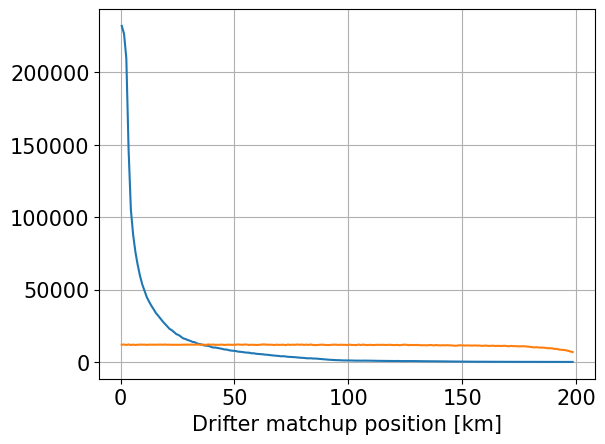

In [77]:

middle_bins_km = (bins[:-1] + (bins[1]-bins[0])/2)/1000
fig, ax = plt.subplots()
ax.plot(middle_bins_km, histx, label = 'X')
ax.plot(middle_bins_km, histy, label ='Y')

ax.grid()
ax.set_xlabel('Drifter matchup position [km]')

# High latitude

In [78]:
DSlat = dict()
for l in DSuf :
    _ds = DSuf[l].where(abs(DSuf[l]['drifter_lat'])>60)
    DSlat[l] = _ds
    print(l)

gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019
gps_Cryosat-2_2019
argos_Cryosat-2_2019
gps_Sentinel-3_A_2019
argos_Sentinel-3_A_2019
gps_Sentinel-3_B_2019
argos_Sentinel-3_B_2019
gps_Jason-3_2018
argos_Jason-3_2018
gps_SARAL_2018
argos_SARAL_2018
gps_Cryosat-2_2018
argos_Cryosat-2_2018
gps_Sentinel-3_A_2018
argos_Sentinel-3_A_2018
gps_Sentinel-3_B_2018
argos_Sentinel-3_B_2018
gps_Jason-3_2017
argos_Jason-3_2017
gps_Jason-2_2017
argos_Jason-2_2017
gps_SARAL_2017
argos_SARAL_2017
gps_Cryosat-2_2017
argos_Cryosat-2_2017
gps_Sentinel-3_A_2017
argos_Sentinel-3_A_2017
gps_Jason-3_2016
argos_Jason-3_2016
gps_Jason-2_2016
argos_Jason-2_2016
gps_SARAL_2016
argos_SARAL_2016
gps_Cryosat-2_2016
argos_Cryosat-2_2016
gps_Sentinel-3_A_2016
argos_Sentinel-3_A_2016
gps_Jason-2_2015
arg

Text(0.5, 0, 'Drifter matchup position [km]')

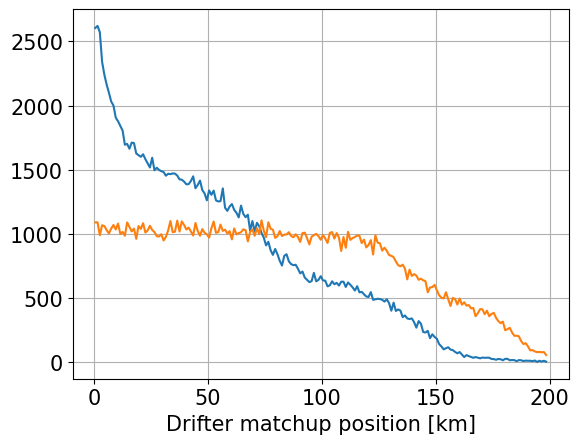

In [79]:
histxl, histyl = plot_xy_hist(DSlat)
middle_bins_km = (bins[:-1] + (bins[1]-bins[0])/2)/1000
fig, ax = plt.subplots()
ax.plot(middle_bins_km, histxl, label = 'X')
ax.plot(middle_bins_km, histyl, label ='Y')
ax.grid()
ax.set_xlabel('Drifter matchup position [km]')

# low latitude

In [80]:
DSlatl = dict()
for l in DSuf :
    _ds = DSuf[l].where(abs(DSuf[l]['drifter_lat'])<30)
    DSlatl[l] = _ds
    print(l)

gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019
gps_Cryosat-2_2019
argos_Cryosat-2_2019
gps_Sentinel-3_A_2019
argos_Sentinel-3_A_2019
gps_Sentinel-3_B_2019
argos_Sentinel-3_B_2019
gps_Jason-3_2018
argos_Jason-3_2018
gps_SARAL_2018
argos_SARAL_2018
gps_Cryosat-2_2018
argos_Cryosat-2_2018
gps_Sentinel-3_A_2018
argos_Sentinel-3_A_2018
gps_Sentinel-3_B_2018
argos_Sentinel-3_B_2018
gps_Jason-3_2017
argos_Jason-3_2017
gps_Jason-2_2017
argos_Jason-2_2017
gps_SARAL_2017
argos_SARAL_2017
gps_Cryosat-2_2017
argos_Cryosat-2_2017
gps_Sentinel-3_A_2017
argos_Sentinel-3_A_2017
gps_Jason-3_2016
argos_Jason-3_2016
gps_Jason-2_2016
argos_Jason-2_2016
gps_SARAL_2016
argos_SARAL_2016
gps_Cryosat-2_2016
argos_Cryosat-2_2016
gps_Sentinel-3_A_2016
argos_Sentinel-3_A_2016
gps_Jason-2_2015
arg

Text(0.5, 0, 'Drifter matchup position [km]')

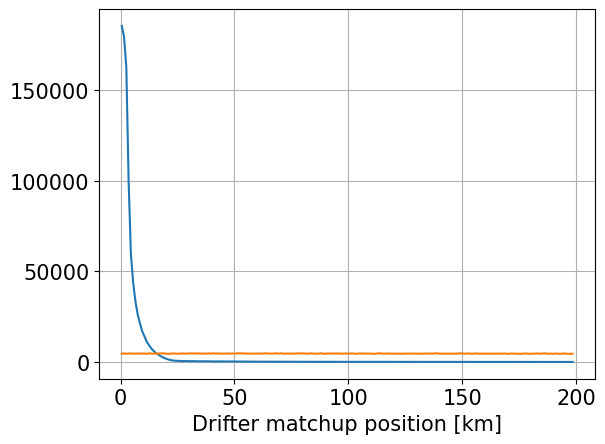

In [81]:
histxll, histyll = plot_xy_hist(DSlatl)
middle_bins_km = (bins[:-1] + (bins[1]-bins[0])/2)/1000
fig, ax = plt.subplots()
ax.plot(middle_bins_km, histxll, label = 'X')
ax.plot(middle_bins_km, histyll, label ='Y')
ax.grid()
ax.set_xlabel('Drifter matchup position [km]')

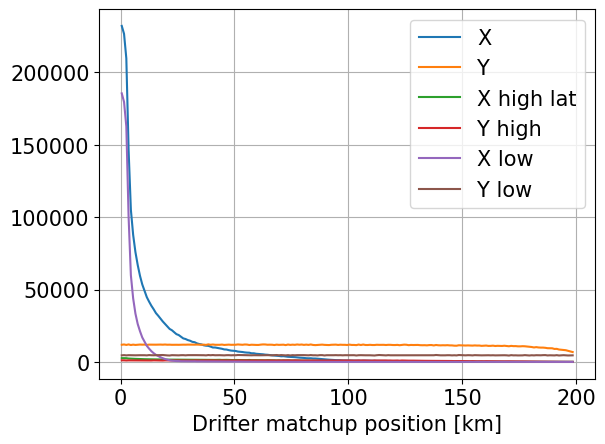

In [82]:

middle_bins_km = (bins[:-1] + (bins[1]-bins[0])/2)/1000
fig, ax = plt.subplots()
ax.plot(middle_bins_km, histx, label = 'X')
ax.plot(middle_bins_km, histy, label ='Y')
ax.plot(middle_bins_km, histxl, label = 'X high lat')
ax.plot(middle_bins_km, histyl, label ='Y high')
ax.plot(middle_bins_km, histxll, label = 'X low')
ax.plot(middle_bins_km, histyll, label ='Y low')
ax.grid()
ax.set_xlabel('Drifter matchup position [km]')
ax.legend()

In [83]:
cluster.close()

distributed.batched - INFO - Batched Comm Closed <TCP (closed)  local=tcp://10.148.0.26:45483 remote=tcp://10.148.0.26:34269>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/tornado/gen.py", line 767, in run
    value = future.result()
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/comm/tcp.py", line 268, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError
